In [0]:
# Source: https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
!pip install -r drive/My\ Drive/zoo/requirements.txt


     |████████████████████████████████| 686kB 2.7MB/s 
     |████████████████████████████████| 256kB 13.6MB/s 
     |████████████████████████████████| 204kB 15.5MB/s 
     |████████████████████████████████| 245kB 16.3MB/s 
  Created wheel for visdom: filename=visdom-0.1.8.9-cp36-none-any.whl size=655250 sha256=7829060baf9d1ddff8473d760d9e5dbc82aef45ed7adaa3fb1058292b374a45f
  Stored in directory: /root/.cache/pip/wheels/70/19/a7/6d589ed967f4dfefd33bc166d081257bd4ed0cb618dccfd62a
  Created wheel for torchfile: filename=torchfile-0.1.0-cp36-none-any.whl size=5712 sha256=3f6f6c402f6fafa5eb779901199c87105b3ef7cfa0852aabdd0e00dd412bf6e5
  Stored in directory: /root/.cache/pip/wheels/b1/c3/d6/9a1cc8f3a99a0fc1124cae20153f36af59a6e683daca0a0814
Successfully built visdom torchfile


In [0]:
from __future__ import print_function
#%matplotlib inline
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
# Set random seed for reproducibility
manualSeed = 453
random.seed(manualSeed)
torch.manual_seed(manualSeed)
model = torch.hub.load("facebookresearch/pytorch_GAN_zoo", "DCGAN", useGPU = True, pretrained = True)

Using cache found in /root/.cache/torch/hub/facebookresearch_pytorch_GAN_zoo_master


Average network found !


In [0]:
netG = model.netG
netD = model.netD

In [0]:
! unzip drive/My\ Drive/edgeOnly.zip > /dev/null # Dont show any output

replace edgeOnly/.DS_Store? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [0]:
# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1
# Number of workers for dataloader
workers = 4
# Location to save images and logs 
img_save_dir = "drive/My Drive/TF_result/"
# Spatial size of training images. All images will be resized to this
#   size using a transformer.
image_size = 64
# Number of channels in the training images. For color images this is 3
nc = 3
# Location of data directory
data_dir = "edgeOnly"
# set up log and save directories
log_dir = img_save_dir
save_model_dir = img_save_dir
# Batch size during training
batch_size = 16
# Size of z latent vector (i.e. size of generator input)
nz = 120
# Learning rate for optimizers
lr = 0.0002
# Beta1 hyperparam for Adam optimizers
beta1 = 0.5
# Number of training epochs
num_epochs = 10
model.config.nEpoch = 10

In [0]:
# We can use an image folder dataset the way we have it setup.
# Create the dataset
dataset = dset.ImageFolder(root=data_dir,
                           transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))
# Create the dataloader
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=workers)

# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")




In [0]:


# Initialize BCELoss function
#criterion = nn.BCELoss()
criterion = nn.BCEWithLogitsLoss()

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(64, nz, 1, 1, device=device)

# Establish convention for real and fake labels during training
real_label = 1
fake_label = 0

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))


# Training Loop

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0

print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, data in enumerate(dataloader, 0):
        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        netD.zero_grad()
        # Format batch
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, device=device)
        # Forward pass real batch through D
        # TODO?
        for k in range(21):
        # output = netD(real_cpu).view(-1)
          output = netD(real_cpu)[:,k]
          # Calculate loss on all-real batch
          errD_real = criterion(output, label)
          # Calculate gradients for D in backward pass
          errD_real.backward(retain_graph=True)
          D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        # Generate fake image batch with G
        fake = netG(noise)
        label.fill_(fake_label)

        for k in range(21):
          # Classify all fake batch with D
          #TODO?
          # output = netD(fake.detach()).view(-1)
          output = netD(fake.detach())[:,k]
          # Calculate D's loss on the all-fake batch
          errD_fake = criterion(output, label)
          # Calculate the gradients for this batch
          errD_fake.backward(retain_graph=True)
          D_G_z1 = output.mean().item()

        # Add the gradients from the all-real and all-fake batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        for k in range(21):
          #TODO
          # output = netD(fake).view(-1)
          output = netD(fake)[:,k]
          # Calculate G's loss based on this output
          errG = criterion(output, label)
          # Calculate gradients for G
          errG.backward(retain_graph=True)
          D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()

        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1

Starting Training Loop...


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1340: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


[0/10][0/52]	Loss_D: 2.6081	Loss_G: 1.0390	D(x): 0.5953	D(G(z)): 0.9643 / 0.8693
[0/10][50/52]	Loss_D: 0.0752	Loss_G: 3.3931	D(x): 5.3112	D(G(z)): -3.1839 / -3.3329
[1/10][0/52]	Loss_D: 0.0699	Loss_G: 3.7379	D(x): 5.3121	D(G(z)): -3.5290 / -3.6822
[1/10][50/52]	Loss_D: 0.0504	Loss_G: 3.7853	D(x): 6.4506	D(G(z)): -3.6852 / -3.7401
[2/10][0/52]	Loss_D: 0.0470	Loss_G: 3.9267	D(x): 6.2510	D(G(z)): -3.7549 / -3.8897
[2/10][50/52]	Loss_D: 0.0133	Loss_G: 5.2139	D(x): 7.0013	D(G(z)): -5.1141 / -5.2027
[3/10][0/52]	Loss_D: 0.0229	Loss_G: 4.7974	D(x): 6.2898	D(G(z)): -4.6716 / -4.7791
[3/10][50/52]	Loss_D: 0.0168	Loss_G: 5.2696	D(x): 6.6152	D(G(z)): -5.1806 / -5.2564
[4/10][0/52]	Loss_D: 0.0099	Loss_G: 5.4075	D(x): 6.1605	D(G(z)): -5.3199 / -5.4015
[4/10][50/52]	Loss_D: 0.0086	Loss_G: 5.8807	D(x): 7.2662	D(G(z)): -5.7089 / -5.8750
[5/10][0/52]	Loss_D: 0.0054	Loss_G: 6.0146	D(x): 7.7280	D(G(z)): -5.8625 / -6.0104
[5/10][50/52]	Loss_D: 0.0039	Loss_G: 6.1229	D(x): 7.8006	D(G(z)): -6.0197 / -6.1199


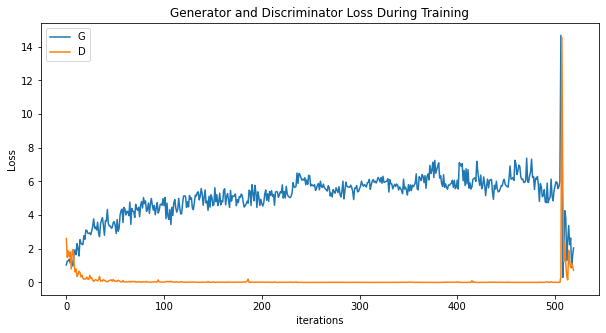

In [0]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

NameError: ignored

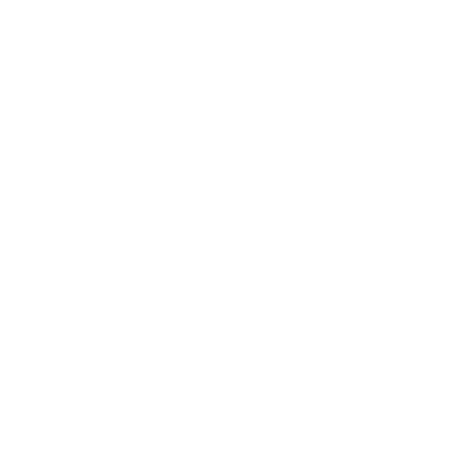

In [0]:
#%%capture
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())

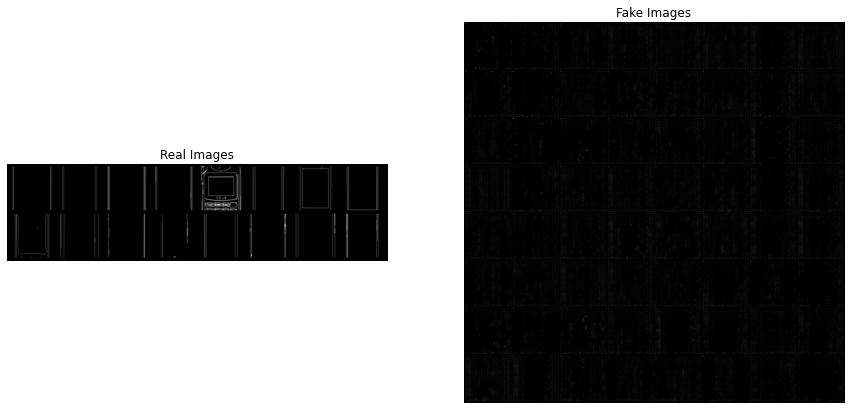

In [0]:
# Grab a batch of real images from the dataloader
real_batch = next(iter(dataloader))

# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.savefig(img_save_dir+"_GENERATEDimage.png",bbox_inches='tight',pad_inches=0)
plt.show()

# plt.savefig(img_save_dir+"_GENERATEDimage.png",bbox_inches='tight',pad_inches=0)